## Challenge Set 11
Name: Adam Levin  
Topic: Mongo and Twitter  
Date: 8/14/2016

In [192]:
import pickle
with open("heavy_metal_parsed.pkl", 'r') as datafile:
    heavy_metal_reviews = pickle.load(datafile)

In [193]:
first_review = heavy_metal_reviews[0]
for line in first_review['raw'][0:5]:
    print line

200 MOTELS (1971)
DIRECTORS: Tony Palmer, Frank Zappa
CAST: Frank Zappa, Ringo Starr, Mark Volman, Howard Kaylan, Keith
Moon
METAL CRED
Frank Zappa


In [194]:
print first_review.keys()

['head', 'metal_cred', 'title', 'direct', 'solid_metal_nuggets', 'cast', 'raw', 'the_meat', 'year', 'sections']


In [279]:
from pymongo import MongoClient
import pymongo
client = MongoClient()

In [215]:
db = client.heavy_metal
reviews = db.reviews

In [216]:
reviews.insert_many(heavy_metal_reviews)

In [217]:
reviews.count()

856

**Challenge 1**

In [218]:
years = [res['year'] for res in reviews.find({},{'year':1,'_id':0})]

In [219]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

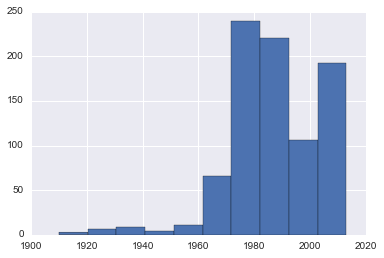

In [220]:
plt.hist(years);

Many more metal movies starting around 1970

**Challenge 2**

In [221]:
appearances = [star for cast in [res['cast'] for res in 
               reviews.find({},{'cast':1,'_id':0})] for star in cast if star!='']

In [222]:
appearances[0:5]

[u'Frank Zappa',
 u'Ringo Starr',
 u'Mark Volman',
 u'Howard Kaylan',
 u'Keith Moon']

In [223]:
from collections import Counter

In [224]:
appearances_counter = Counter(appearances)
for key in sorted(appearances_counter,key=appearances_counter.get)[::-1][:5]:
    print key,appearances_counter[key]

Alice Cooper 15
Christopher Lee 14
Arnold Schwarzenegger 10
Ozzy Osbourne 9
Gwar 8


I think that name makes sense.

**Challenge 3**

In [225]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [226]:
title_blob = [word.lower() for spl in [title.split() for title in [res['title'] for res in 
               reviews.find({},{'title':1,'_id':0})]] for word in spl if word.lower() not in ENGLISH_STOP_WORDS]

In [227]:
title_blob[0:7]

[u'200', u'motels', u'300', u'1984', u'1990:', u'bronx', u'warriors']

In [228]:
title_words_counter = Counter(title_blob)
for key in sorted(title_words_counter,key=title_words_counter.get)[::-1][:5]:
    print key,title_words_counter[key]

metal 29
dead 23
heavy 18
rock 17
black 14


Seems right.

**Challenge 4**

In [229]:
metal_cred = [res['metal_cred'] for res in reviews.find({},{'metal_cred':1,'_id':0})]

In [230]:
import pandas as pd

In [231]:
metal_cred = pd.DataFrame({'year':years,'metal_cred':metal_cred})
metal_cred = metal_cred[['year','metal_cred']]

In [232]:
metal_cred.head(3)

,year,metal_cred
0,1971,"[METAL CRED, Frank Zappa, Nun Desecration]"
1,2006,"[METAL CRED, Sword and Sorcery, Battle Elephan..."
2,1984,"[METAL CRED, Post-Apocalypse, Big Brother, 198..."


METAL CRED should not be a metal_cred so I will exclude that one.

In [233]:
metal_cred['decade'] = [(year-1900)/10 for year in metal_cred.year]

In [234]:
metal_cred.decade.value_counts()

8     287
10    162
7     160
9     108
11     71
6      39
3       8
5       7
2       7
4       5
1       2
Name: decade, dtype: int64

In [235]:
metal_cred = metal_cred[metal_cred.decade.isin([7,8,9,10])].drop('year',axis=1)

In [236]:
for decade,df in metal_cred.groupby('decade'):
    print 'Decade: %d' % (10*decade+1900,)
    metal_cred_counter = Counter([mc.encode('ascii','replace').replace('?',' ').replace('\n','').lower().strip() for lmc in df.metal_cred for mc in lmc if mc!='METAL CRED'])
    print
    for key in sorted(metal_cred_counter,key=metal_cred_counter.get)[::-1][:5]:
        print key,metal_cred_counter[key]
    print

Decade: 1970

satan 19
black mass 10
video nasty 7
post-apocalypse 7
zombies 6

Decade: 1980

post-apocalypse 29
sword and sorcery 21
satan 16
80s slasher 13
video nasty 12

Decade: 1990

satan 7
gwar 6
post-apocalypse 4
lemmy 4
ozzy osbourne 3

Decade: 2000

torture porn 11
satan 7
metalcred 5
jigsaw 4
music score: charlie clouser 4



This just got dark..

**Challenge 5**

In [250]:
for doc in reviews.find():
     reviews.update_one({'_id': doc['_id']},{"$set":{'metal_score':len(doc['metal_cred'])}})

**Challenge 6**

In [263]:
directors = [res['direct'] for res in reviews.find({},{'direct':1,'_id':0})]
metal_score = [res['metal_score'] for res in reviews.find({},{'metal_score':1,'_id':0})]
directors_score = pd.DataFrame({'directors':directors,'metal_score':metal_score})

In [269]:
from collections import defaultdict
d_scores = defaultdict(list)
for index,row in directors_score.iterrows():
    for d in row.directors:
        if d!='':
            d_scores[d].append(row.metal_score)

In [271]:
import numpy as np
d_ave_scores = {key:np.mean(d_scores[key]) for key in d_scores}

In [272]:
for key in sorted(d_ave_scores,key=d_ave_scores.get,reverse=True)[0:5]:
    print key,d_ave_scores[key]

John Milius 75.0
David Jacobson 27.0
Robert Hendrickson 18.0
Laurence Merrick 18.0
Tinto Brass 13.0


That guy must be really hardcore.

**Challenge 7**

In [274]:
cast = [res['cast'] for res in reviews.find({},{'cast':1,'_id':0})]

In [276]:
collaborator_count = defaultdict(int)
for c,d in zip(cast,directors):
    for actor in c:
        if actor!='':
            for director in d:
                if director!='':
                    collaborator_count[(actor,director)] += 1

In [277]:
for key in sorted(collaborator_count,key=collaborator_count.get,reverse=True)[0:5]:
    print key,collaborator_count[key]

(u'Christopher Lee', u'Peter Jackson') 4
(u'Sheri Moon Zombie', u'Rob Zombie') 4
(u'George Eastman', u'Joe D\u2019Amato') 4
(u'Daria Nicolodi', u'Dario Argento') 4
(u'Jason Baldwin', u'Joe Berlinger') 3


**Challenge 8**

In [297]:
result = reviews.create_index([('direct', pymongo.ASCENDING)],unique=False)

In [298]:
list(reviews.index_information())

[u'direct_1', u'_id_']

**Twitter API**

In [304]:
import requests
from requests_oauthlib import OAuth1

In [305]:
import cnfg
config = cnfg.load(".twitter_config")

oauth = OAuth1(config["consumer_key"],
               config["consumer_secret"],
               config["access_token"],
               config["access_token_secret"])

In [357]:
db = client['dogparty']
dog_party = db.dog_party

In [350]:
parameters = {"q": ["dog, party"], 'language':'en', "count":1500, "exclude":'nativeretweets',"exclude":'retweets'}
response = requests.get("https://api.twitter.com/1.1/search/tweets.json",
                        params = parameters,
                        auth=oauth)

In [351]:
tweets = response.json()['statuses']

In [352]:
for tweet in tweets[0:10]:
    print tweet['user']['screen_name'],tweet['favorite_count'],tweet['retweet_count'],tweet['text'].encode('ascii','ignore')

twigs_ebooks 2 0 I'm at a house party bitches. Im plsying beer pong the dog stole the ball lol.
Guy_yop_025 0 0 https://t.co/TsQfw2im2I #4862 12x Female Pet Dog Dress Christmas Party Wear Moustache Fancy Costume Apparel M https://t.co/v5vKBWz7rg
hellaubs 0 0 The best thing that can happen at a party is getting to meet a new dog 
kimberlyghughes 0 0 Mom Comes Home And Confronts Her Dog About The Giant Mess. He Points and Rats Out The Guilty Party. https://t.co/oMD3j0hTPg
WXU_DEZ_052 0 0 https://t.co/tE5lqzhR4D #7172 SHABBY PINK LACE SIZE XSMALL DOG HARNESS DRESS PET WEDDING PARTY Bridesmaid https://t.co/KVwUKpOLIy
uusseerrnnaamm 0 0 At a party for a dog with a bunch of old people. Where is my mind?
lindywestdorp 0 0 found a dog at a party  and b&amp;w theme is hard https://t.co/zew6eD6IbH
kaylzcurly 0 0 I'm out at a house party and I'm literally no lying spooning the massive dog in the middle of the living room #lifegoals #lovedogs 
Sophiiep99 2 0 My dog is my life ofc hes gonna have a 

In [358]:
for tweet in tweets:
    data = {}
    data['screen_name'] = tweet['user']['screen_name']
    data['favorite_count'] = tweet['favorite_count']
    data['retweet_count'] = tweet['retweet_count']
    data['text'] = tweet['text'].encode('ascii','ignore')
    dog_party.insert_one(data)

In [359]:
dog_party.count()

100